# Heart Failure Prediction - IA01 Project Autumn 2025
# UTT - Introduction to Artificial Intelligence
 
This notebook contains the exploratory data analysis, data preprocessing, 
and machine learning modeling steps for predicting heart failure. 
The dataset used combines multiple sources including Cleveland, Hungarian, 
Switzerland, Long Beach VA, and Stalog datasets, resulting in 918 observations 
after removing duplicates.

The goal is to analyze the dataset, identify important features, 
train several classification models (kNN, Decision Tree, Random Forest,
Logistic Regression, Neural Networks), and evaluate their performance.


# Helpers

In [261]:
from sklearn.model_selection import train_test_split
def hist_box(feature, data):
    plt.figure(figsize = (15,5))
    plt.subplot(1,2,1)
    sns.histplot(x=feature, data=data)
    plt.subplot(1,2,2)
    sns.boxplot(y=feature, data=data)
    plt.tight_layout()
    plt.show()

In [262]:
def IQR(feature, data):
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return lower, upper

# We import important libraries to analyze the dataset
 

In [263]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import KNNImputer

# EDA

## Dataset Loading & Basic Structure

In [264]:
heart_data = pd.read_csv('/data/heart.csv')
print(f"In our dataset we have {heart_data.shape[0]} rows and {heart_data.shape[1]} columns\n")
print(heart_data.head())

In our dataset we have 918 rows and 12 columns

   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  


In [265]:
heart_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


## Deviding data into data types and splitting into X, y

In [266]:
numerical_variables = ["Age", "RestingBP", "Cholesterol", "FastingBS", "MaxHR", "Oldpeak"]
# categorical variables - maybe one-hot encoding
nominal_variables = ["Sex", "ExerciseAngina"]
# categorical variables with order which is important
ordinal_variables = ["ST_Slope", "ChestPainType", "RestingECG"]
for variable in ordinal_variables:
    print(heart_data[variable].unique())
target_variable = ["HeartDisease"]

X = heart_data.drop(target_variable, axis=1)
y = heart_data[target_variable]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

['Up' 'Flat' 'Down']
['ATA' 'NAP' 'ASY' 'TA']
['Normal' 'ST' 'LVH']


## Univariate Analysis — Numeric Features

In [267]:
numeric_features = heart_data.select_dtypes(include='number').columns.tolist()

In [268]:
print(numeric_features)

['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'HeartDisease']


### Age analysis

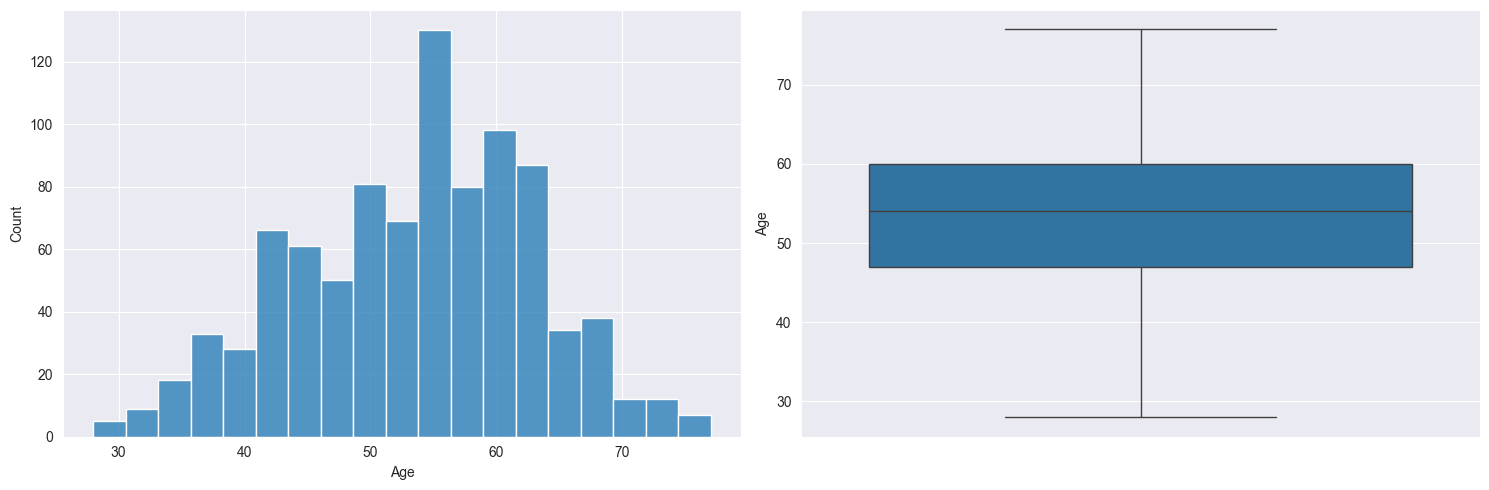

In [269]:
hist_box(numeric_features[0], heart_data)

- The histogram shows that **Age** is approximately normally distributed, with most patients between **45 and 65 years old**, which is typical for a heart-disease-focused dataset.
- The boxplot indicates a relatively symmetric distribution with no extreme outliers.
- Conclusion: Age is a clean and reliable feature, that describes the population that is from middle-aged to older adults, aligning with known risk groups for heart disease.

### RestingBP analysis

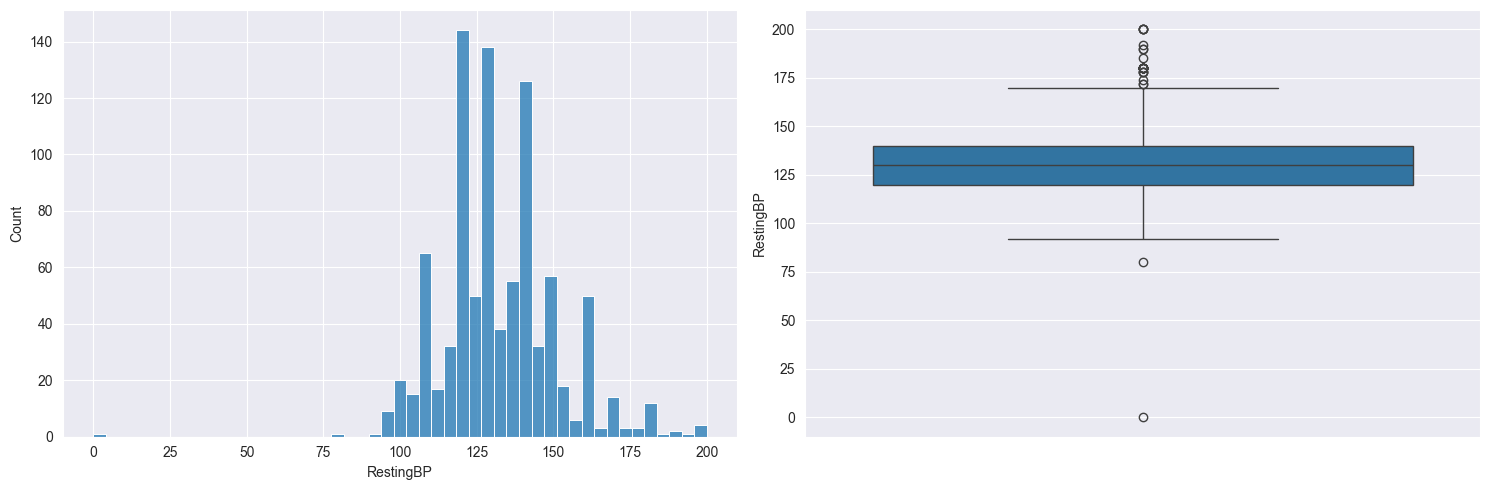

In [270]:
hist_box(numeric_features[1], heart_data)

In [271]:
print(f"We have {heart_data.RestingBP[heart_data['RestingBP'] > IQR('RestingBP', heart_data)[1]].count()} values that look like outliers (higher than {IQR('RestingBP', heart_data)[1]})")

We have 26 values that look like outliers (higher than 170.0)


   - The histogram for **RestingBP** shows a roughly centered distribution around **120–140 mmHg**, which is consistent with typical resting blood pressure ranges in adults.
   - A single value at **0 mmHg** appears in both the histogram and boxplot, which is physiologically impossible and indicates an erroneous or missing measurement.
   - The boxplot also reveals several high outliers above **170 mmHg**, we can conclude that these values are likely describing hypertensive patients rather than data errors.

### Cholesterol analysis

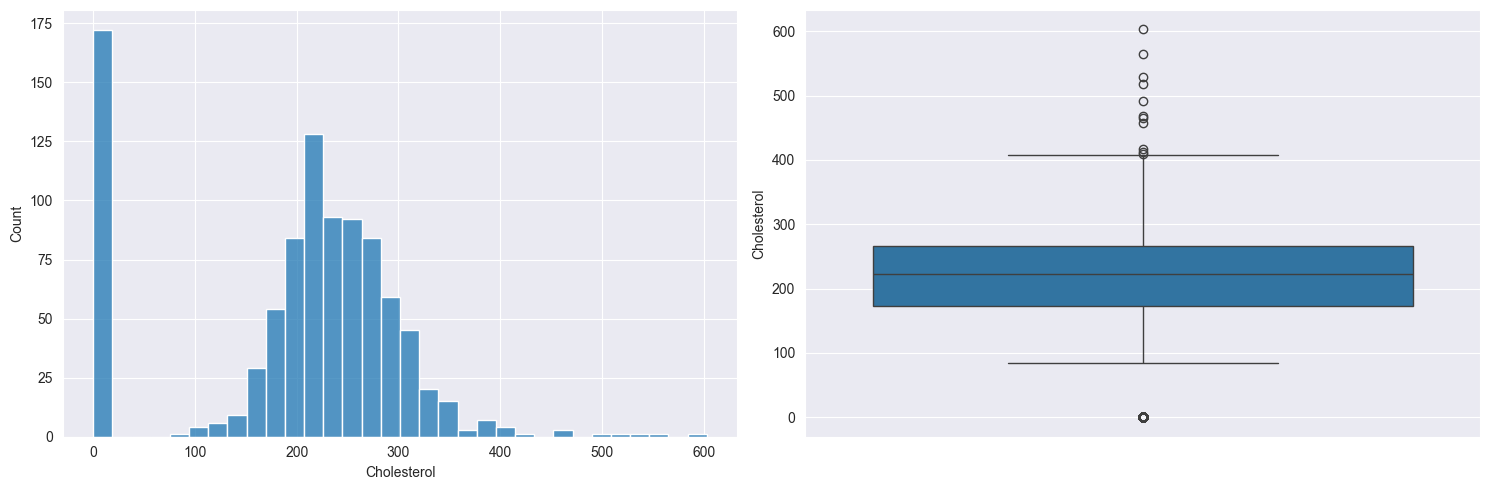

In [272]:
hist_box(numeric_features[2], heart_data)

In [273]:
print(f"We have {heart_data.Cholesterol[heart_data.Cholesterol > IQR('Cholesterol', heart_data)[1]].count()} values that look like outliers, but are clinically plausible")
print(f"We have {heart_data.Cholesterol[heart_data.Cholesterol == 0].count()} values that are equals 0, which is medically impossible and indicates erroneous or missing cholesterol values that must be corrected")

We have 11 values that look like outliers, but are clinically plausible
We have 172 values that are equals 0, which is medically impossible and indicates erroneous or missing cholesterol values that must be corrected


- The histogram shows a large spike at **0 mg/dl**, which is medically impossible and indicates erroneous or missing cholesterol values that must be corrected.
- Among valid measurements, cholesterol follows a right-skewed distribution centered around **200–260 mg/dl**, with several high outliers above **400 mg/dl**.
- The boxplot confirms both the invalid zero values and the presence of clinically plausible high-cholesterol outliers.

### FastingBS analysis

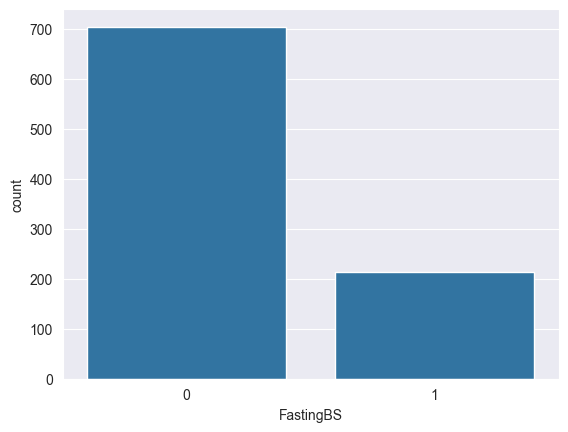

In [274]:
sns.countplot(x=numeric_features[3], data=heart_data)
plt.show()

In [275]:
fastingBS_info = heart_data.FastingBS.value_counts(normalize=True)
print(f"We have {fastingBS_info[0] * 100:.2f} % of patients who have normal glucose levels and {fastingBS_info[1] * 100:.2f} % of patients who have elevated fasting blood sugar")

We have 76.69 % of patients who have normal glucose levels and 23.31 % of patients who have elevated fasting blood sugar


 - The bar plot shows that most patients have a fasting blood sugar value of **0**, meaning normal glucose levels, while a smaller portion 23.31 % have elevated fasting blood sugar (value **1**). This reflects the expected distribution in a general or clinical population, where high fasting sugar is less common. Because FastingBS is a binary variable, no outliers or unusual patterns are present.

### MaxHR analysis

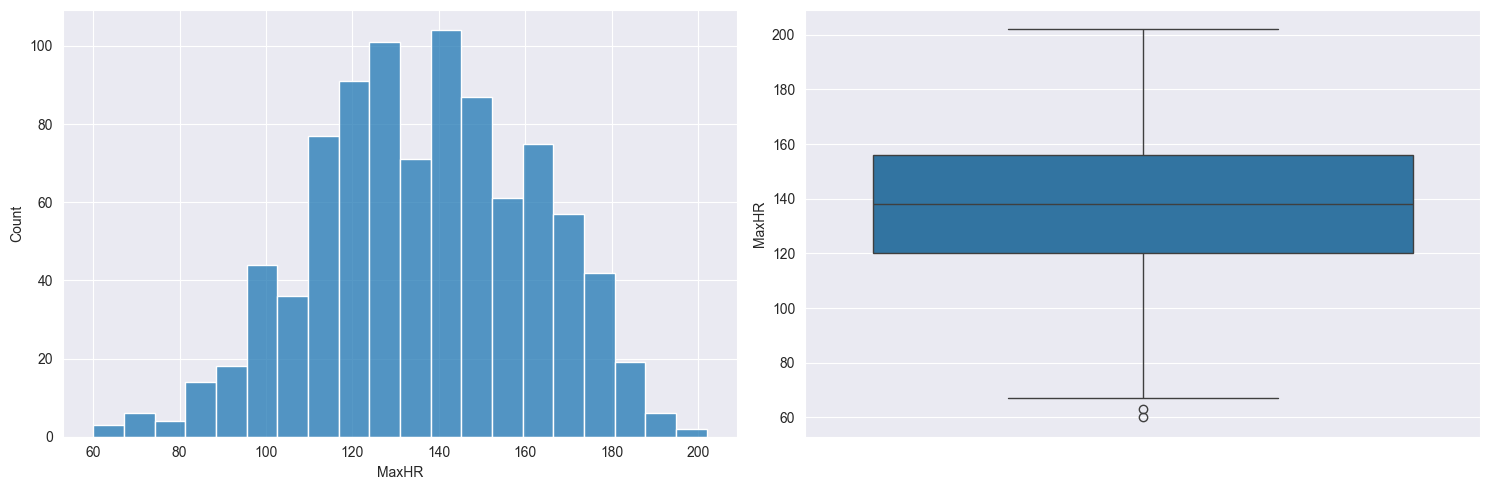

In [276]:
hist_box(numeric_features[4], heart_data)

In [277]:
print(f"We have {heart_data.MaxHR[heart_data.MaxHR < IQR(numeric_features[4], heart_data)[0]].count()} values that are less than {IQR(numeric_features[4], heart_data)[0]} that can represent an unusual clinical cases because most values are between 120 and 160bpm")

We have 2 values that are less than 66.0 that can represent an unusual clinical cases because most values are between 120 and 160bpm


- The histogram shows that MaxHR is mostly concentrated between **120 and 160 bpm**, forming an approximately bell-shaped distribution typical for exercise stress testing.
- A small number of very low values, such as **60 bpm**, appear in the boxplot and represent unusual or clinically concerning cases, possibly due to incomplete exercise tests or severe cardiac limitations. Overall, the feature looks clean but contains a few physiologically extreme low outliers worth noting.

###  Oldpeak analysis

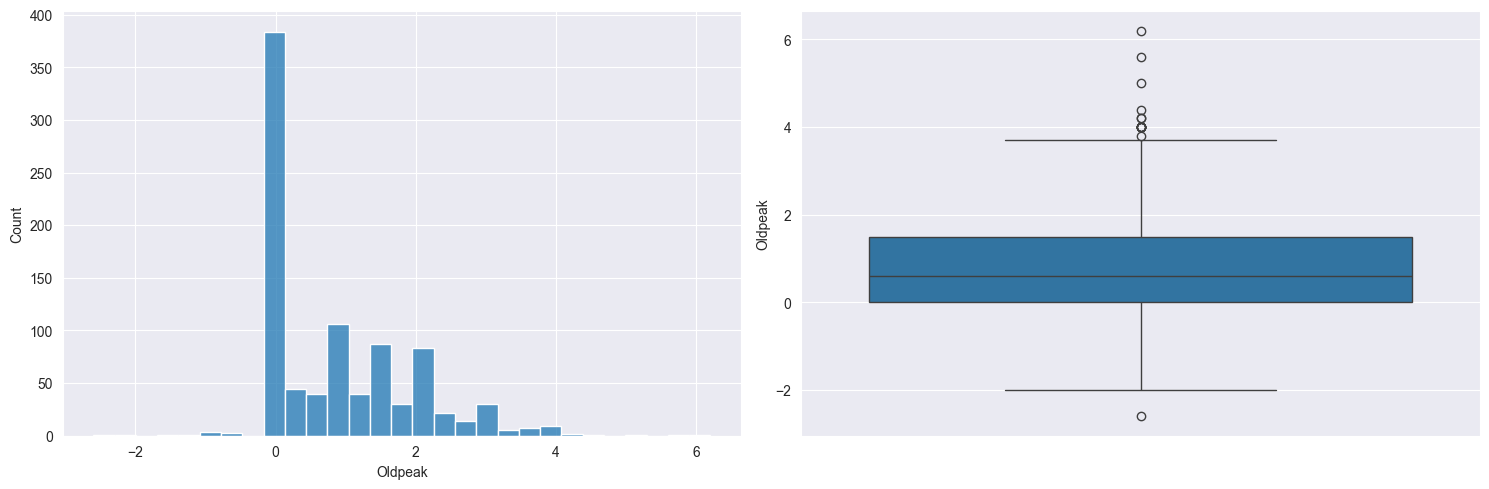

In [278]:
hist_box(numeric_features[5], heart_data)

In [279]:
print(f"We have {heart_data.Oldpeak[heart_data.Oldpeak < 0].count()} that are less than 0 that can be strange and we can probably replace them by 0")
print(f"We have also {heart_data.Oldpeak[heart_data.Oldpeak > IQR(numeric_features[5], heart_data)[1]].count()} values that are outliers and higher than {IQR(numeric_features[5], heart_data)[1]}")

We have 13 that are less than 0 that can be strange and we can probably replace them by 0
We have also 15 values that are outliers and higher than 3.75


- The histogram shows that Oldpeak is heavily right-skewed, with the majority of values clustered at 0, indicating no ST depression during exercise, while higher values up to **6** represent more severe abnormalities.
- The boxplot highlights several high outliers above **4**, which likely correspond to patients with significant cardiac stress responses. A few negative values also appear, which can occur due to ECG baseline shifts, but they remain rare and should be kept in mind during preprocessing.

## Univariate Analysis — Ordinal Features

In [280]:
print(ordinal_variables)

['ST_Slope', 'ChestPainType', 'RestingECG']


### St_Slope analysis

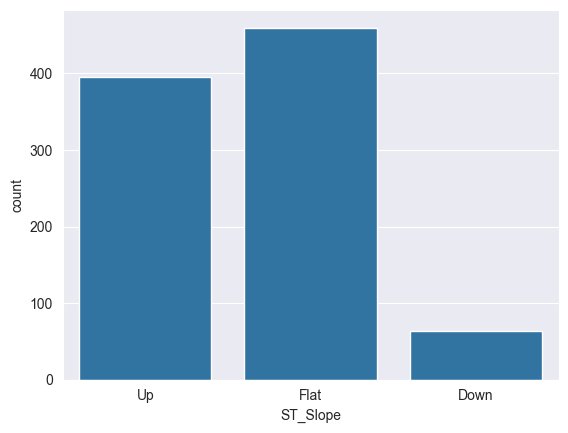

We have 460 flat values,  395 up values and 63 down values


In [281]:
sns.countplot(x="ST_Slope", data=heart_data)
plt.show()
st_slope_info = heart_data["ST_Slope"].value_counts().tolist()
print(f"We have {st_slope_info[0]} flat values,  {st_slope_info[1]} up values and {st_slope_info[2]} down values")

The analysis of the ST_Slope variable shows that the categories are imbalanced, with most observations labeled as Flat or Up, and relatively few labeled as Down. Despite this imbalance, the ordered nature of the feature makes it medically and statistically meaningful.

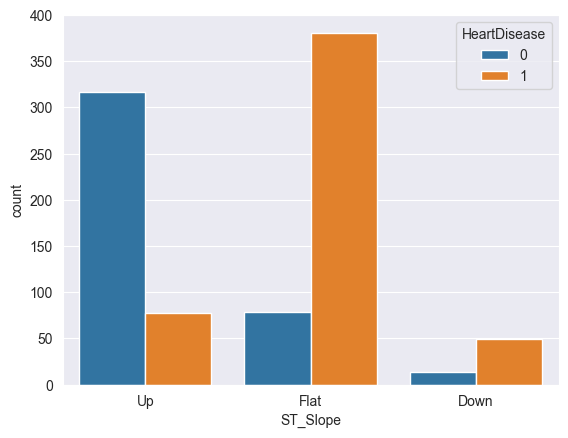

In [282]:
sns.countplot(data=heart_data, x="ST_Slope", hue="HeartDisease")
plt.show()

Comparing ST_Slope with the target variable (Heart disease) can bring us to this conclusion:
- Individuals with a **Flat** ST_Slope are most likely to have Heart Disease
- A majority of individuals with an **Up** ST_Slope do not have Heart Disease
- While the overall counts are low for this group, those with a **Down** ST_Slope are also more likely to have Heart Disease

### RestingECG

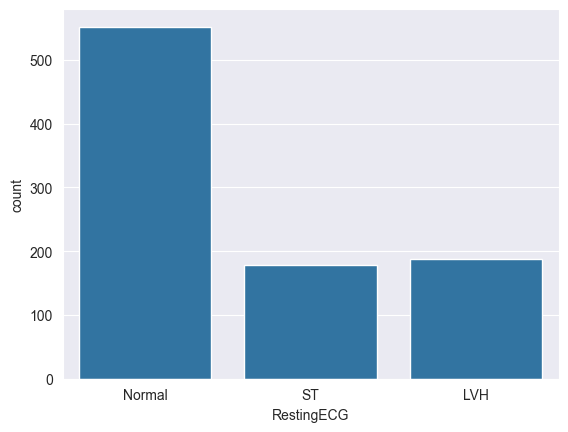

[552, 188, 178]


In [283]:
sns.countplot(x="RestingECG", data=heart_data)
plt.show()
restingECG_info = heart_data["RestingECG"].value_counts().tolist()
print(restingECG_info)

The RestingECG variable is dominated by the Normal category, while LVH and ST are less frequent. This imbalance should be considered when analyzing its relationship with heart disease. Despite fewer cases in LVH and ST, differences across categories may still provide valuable insights into cardiac risk and can be used effectively in predictive modeling after appropriate encoding.

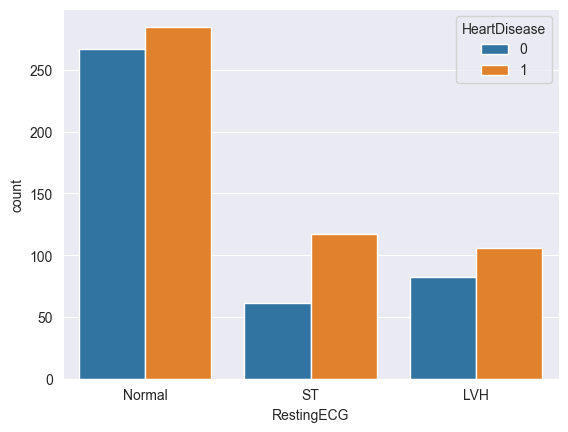

In [284]:
sns.countplot(data=heart_data, x="RestingECG", hue="HeartDisease")
plt.show()

The RestingECG provide 3 groups: Normal, ST and Left Ventricular Hypertrophy(LVH).
- Normal:
    - Has the largest total number of people
    - Having a 'Normal' RestingECG does not guarantee the absence of heart disease, as the disease is slightly more prevalent even in this group.
- ST:
    - The count of Heart Disease is clearly much higher than the count of no Heart Disease
    - This group can be a strong indicator for the presence of Heart Disease
- LVH:
    - The count for Heart Disease is higher than the count for no Heart Disease
    - Left Ventricular Hypertrophy is also associated with a higher likelihood of Heart Disease.

### ChestPainType

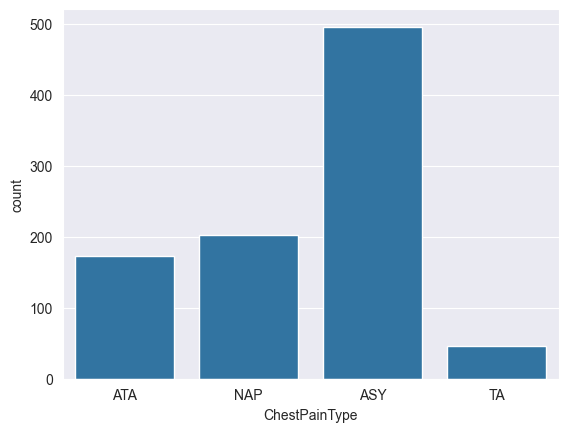

{'ASY': 496, 'NAP': 203, 'ATA': 173, 'TA': 46}


In [285]:
sns.countplot(data=heart_data, x="ChestPainType")
plt.show()
print(heart_data.ChestPainType.value_counts().to_dict())

We have 4 different groups of **chain pain type**: ATA, NAP, ASY, TA. The ChestPainType variable is heavily skewed toward ASY (Asymptomatic, 496 cases), followed by NAP (Non-Anginal Pain, 203 cases), ATA (Atypical Angina, 173 cases), and TA (Typical Angina, 46 cases). Most patients do not report significant chest pain (ASY), while the less frequent categories—especially TA—may indicate higher cardiac risk. Despite their smaller numbers, these rarer pain types provide important predictive information for heart disease when analyzed or properly encoded.

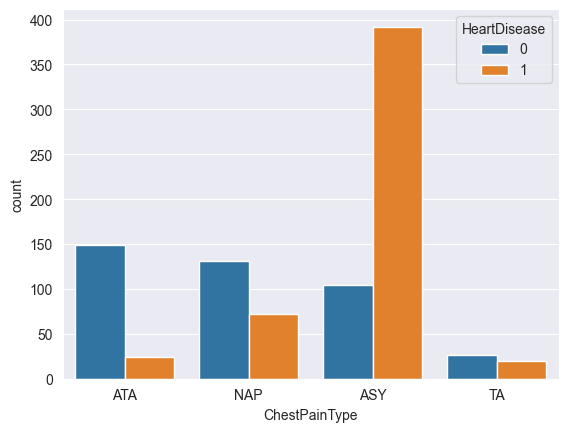

In [286]:
sns.countplot(data=heart_data, x="ChestPainType", hue="HeartDisease")
plt.show()

The ChestPainType provide 4 groups: ATA, NAP, ASY and TA.
- ATA
    - Is strongly associated with the absence of Heart Disease
- NAP
    - Absence of Heart Disease is significantly taller (130 vs 75)
- ASY
    - Highest total count of individuals
    - Associated with Heart Disease because have heart disease is four times higher than not
- TA
    - lowest total count of individuals
    - least informative, have very similar possibilities of having heart disease

## Univariate Analysis — Target Feature

### HeartDisease analysis

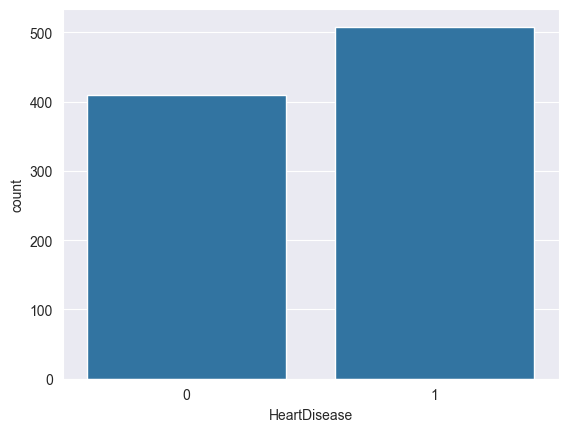

In [287]:
sns.countplot(x=numeric_features[6], data=heart_data)
plt.show()

- The target variable is fairly balanced, with slightly more patients labeled as having heart disease **(1)** than not **(0)**. This moderate class imbalance should not cause major issues during model training but may still benefit from stratified train–test splitting. Overall, the distribution indicates that the dataset contains sufficient examples of both classes for effective classification modeling.

## Descriptive Statistics (Numeric)

In [288]:
heart_data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


The dataset contains 918 samples with seven numerical features, including the target variable `HeartDisease`.
- **Age** ranges from **28 to 77 years** (mean **≈ 53.5**), indicating a predominantly middle-aged population, which is typical for heart disease studies.
- **Resting blood pressure (**RestingBP**)** has an average of 132 mmHg with values ranging from 0 to 200; the minimum value of 0 mmHg is physiologically impossible and therefore corresponds to erroneous or missing measurements that **must be corrected during preprocessing**.
- **Cholesterol** shows a wide range from 0 to 603 mg/dl, with a mean of about 199 mg/dl. The presence of 0 mg/dl again indicates *invalid* entries that should be treated as missing data. Additionally, very high values (above ~500 mg/dl) may be **aberrant or extreme outliers**.  While extremely high cholesterol is medically possible, such values should still be examined carefully to determine whether they represent true measurements or data entry errors.
- **FastingBS** is a binary indicator (0 or 1), which explains its mean of **0.23** and quartiles at **0**.
- **MaxHR** ranges from **60 to 202** bpm, with an average of about **137** bpm, reflecting substantial variability in patients’ exercise capacities.
- **Oldpeak** (ST depression) spans from **–2.6 to 6.2**, suggesting both normal and abnormal ECG responses to exercise and a right-skewed distribution due to higher positive values.

The target variable `HeartDisease` is binary (0 = no heart disease, 1 = heart disease) with a mean of approximately 0.55 and a median and upper quartile equal to 1. This indicates that a bit **more than half of the patients in the dataset are labeled as having heart disease**, so the classes are not perfectly balanced but also not extremely imbalanced.

Overall, the descriptive statistics reveal
  - invalid zero values in some medical measurements (RestingBP, Cholesterol),
  - skewed distributions for certain features
  - a moderate prevalence of heart disease, all of which must be taken into account in the subsequent preprocessing and modeling steps.

## Check for duplicates

In [289]:
print(f" In our dataset we have {heart_data.duplicated().sum()} duplicates")

 In our dataset we have 0 duplicates


## Check for Missing Values

In [290]:
heart_data.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [291]:
heart_data.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

The dataset **doesn't** contains `NaN` or `Null` values.

In [292]:
heart_data.eq(0).sum()

Age                 0
Sex                 0
ChestPainType       0
RestingBP           1
Cholesterol       172
FastingBS         704
RestingECG          0
MaxHR               0
ExerciseAngina      0
Oldpeak           368
ST_Slope            0
HeartDisease      410
dtype: int64

- **RestingBP** contains values equal to 0, which are not physiologically possible.
  This suggests this zero represents missing or incorrectly recorded value that should be either removed or imputed.

- **Cholesterol** also includes 0 values. Since a cholesterol level of 0 is impossible, these should also be treated as missing values.
  In total, there are 172 such entries that need to be handled.

- **FastingBS** can legitimately take the value 0, because the feature is binary (0 = normal, 1 = high).
  Therefore, zeros in this column do **not** represent missing values.

- **Oldpeak** can also legitimately be 0, since it represents ST depression relative to rest.
  Thus, values of 0 here are not missing values.


## Replacing missing values

### Replaicing 0 in RestingBP by mean value

We can delete a row with value 0 in RestingBP column or replace it by mean value as what we have done

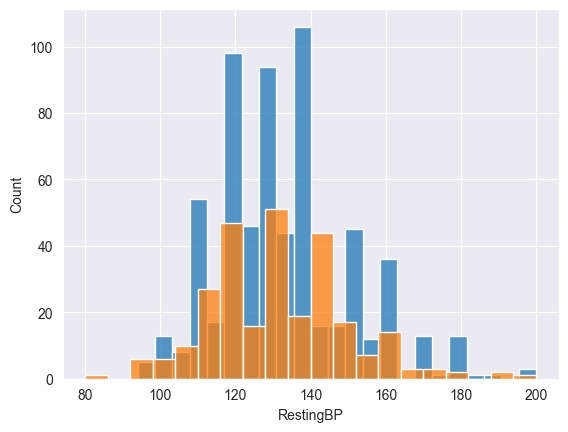

In [293]:
X_train_eda = X_train.copy()
X_test_eda = X_test.copy()
# df_eda = heart_data.copy()
# df_eda.RestingBP = df_eda.RestingBP.replace(0, mean_restingBP)
mean_restingBP = df_eda.RestingBP.replace(0, np.nan).mean()
X_train_eda['RestingBP'] = X_train_eda['RestingBP'].replace(0, mean_restingBP)
X_test_eda['RestingBP'] = X_test_eda['RestingBP'].replace(0, mean_restingBP)
sns.histplot(data=X_train_eda, x="RestingBP")
sns.histplot(data=X_test_eda, x="RestingBP")
plt.show()

### Replaicing 0 in Cholesterol by KNN value

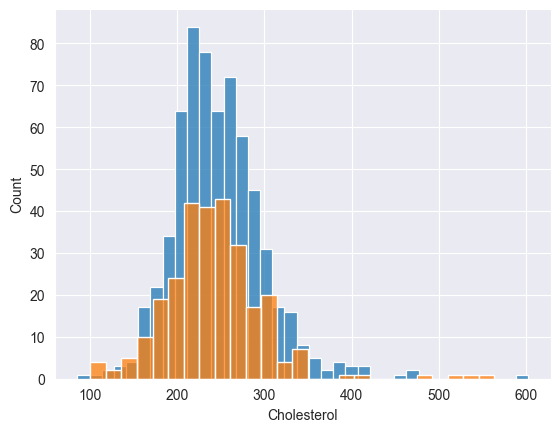

In [294]:
from sklearn.impute import KNNImputer
# KNN doesn't modify existing values and replaces only np.nan, so we need to change o by NaN
X_train_eda.Cholesterol = X_train_eda.Cholesterol.replace(0, np.nan)
X_test_eda.Cholesterol = X_test_eda.Cholesterol.replace(0, np.nan)
imputer = KNNImputer(n_neighbors=5)
imputer_features = ['RestingBP', 'Age', 'Cholesterol', 'MaxHR']
imputed_data_train = imputer.fit_transform(X_train_eda[imputer_features])
imputed_data_test = imputer.transform(X_test_eda[imputer_features])
X_train_eda['Cholesterol'] = imputed_data_train[:, 2]
X_test_eda['Cholesterol'] = imputed_data_test[:, 2]
sns.histplot(data=X_train_eda, x="Cholesterol")
sns.histplot(data=X_test_eda, x="Cholesterol")
plt.show()


## Encoding ordinal features

In [295]:
from sklearn.preprocessing import OrdinalEncoder
categories = [['Down', 'Flat', 'Up'], ['ASY', 'NAP', 'ATA', 'TA'], ['Normal', 'ST', 'LVH']]
ordinal_encoder = OrdinalEncoder(categories=categories)
X_train_eda[ordinal_variables] = ordinal_encoder.fit_transform(X_train_eda[ordinal_variables])
X_test_eda[ordinal_variables] = ordinal_encoder.transform(X_test_eda[ordinal_variables])
print(X_train_eda.shape)



(642, 11)


## Encoding nominal (unordered) categorical variables

In [296]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse_output=False)
train_ohe = one_hot_encoder.fit_transform(X_train_eda[nominal_variables])
test_ohe = one_hot_encoder.transform(X_test_eda[nominal_variables])

# npdarrat to DataFrame
train_ohe_df = pd.DataFrame(train_ohe, columns=one_hot_encoder.get_feature_names_out(nominal_variables))
test_ohe_df = pd.DataFrame(test_ohe, columns=one_hot_encoder.get_feature_names_out(nominal_variables))

# Reset index to align DataFrames
train_ohe_df.index = X_train_eda.index
test_ohe_df.index = X_test_eda.index

# Drop original nominal columns
X_train_eda = X_train_eda.drop(columns=nominal_variables)
X_test_eda = X_test_eda.drop(columns=nominal_variables)

# Concatenate encoded columns
X_train_eda = pd.concat([X_train_eda, train_ohe_df], axis=1)
X_test_eda = pd.concat([X_test_eda, test_ohe_df], axis=1)



Check what our dataset looks like

In [297]:
X_train_eda.head()

,Age,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,Oldpeak,ST_Slope,Sex_F,Sex_M,ExerciseAngina_N,ExerciseAngina_Y
712,58,0.0,100.0,234.0,0,0.0,156,0.1,2.0,0.0,1.0,1.0,0.0
477,61,0.0,110.0,219.0,1,0.0,108,2.0,0.0,0.0,1.0,0.0,1.0
409,53,1.0,160.0,215.0,1,2.0,122,0.0,1.0,0.0,1.0,0.0,1.0
448,63,0.0,160.0,230.0,1,0.0,105,1.0,1.0,0.0,1.0,0.0,1.0
838,63,0.0,130.0,330.0,1,2.0,132,1.8,2.0,0.0,1.0,0.0,1.0


In [298]:
X_train_eda.info()

<class 'pandas.core.frame.DataFrame'>
Index: 642 entries, 712 to 102
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               642 non-null    int64  
 1   ChestPainType     642 non-null    float64
 2   RestingBP         642 non-null    float64
 3   Cholesterol       642 non-null    float64
 4   FastingBS         642 non-null    int64  
 5   RestingECG        642 non-null    float64
 6   MaxHR             642 non-null    int64  
 7   Oldpeak           642 non-null    float64
 8   ST_Slope          642 non-null    float64
 9   Sex_F             642 non-null    float64
 10  Sex_M             642 non-null    float64
 11  ExerciseAngina_N  642 non-null    float64
 12  ExerciseAngina_Y  642 non-null    float64
dtypes: float64(10), int64(3)
memory usage: 70.2 KB


In [299]:
print(X_train_eda.RestingECG.unique())
print(X_train_eda.ST_Slope.unique())
print(X_train_eda.ChestPainType.unique())

[0. 2. 1.]
[2. 0. 1.]
[0. 1. 2. 3.]


## KNN prediction

First we need to scale all numerical values

In [300]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_eda_scaled = scaler.fit_transform(X_train_eda[numerical_variables])
X_test_eda_scaled = scaler.transform(X_test_eda[numerical_variables])

Prediction

In [310]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, precision_score, f1_score

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_eda_scaled, y_train.squeeze())

y_pred = knn.predict(X_test_eda_scaled)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

recall = recall_score(y_test, y_pred)
print("Recall: ", recall)

print(confusion_matrix(y_test, y_pred))


print(classification_report(y_test, y_pred))


Accuracy:  0.7355072463768116
Recall:  0.725609756097561
[[ 84  28]
 [ 45 119]]
              precision    recall  f1-score   support

           0       0.65      0.75      0.70       112
           1       0.81      0.73      0.77       164

    accuracy                           0.74       276
   macro avg       0.73      0.74      0.73       276
weighted avg       0.75      0.74      0.74       276



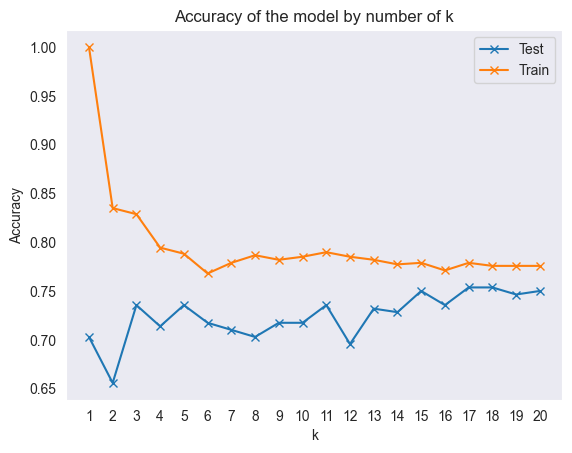

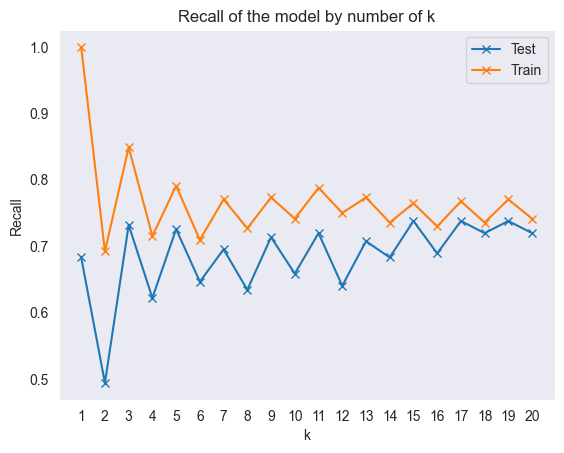

In [311]:
k_values = range(1, 21)
accuracies_test = []
accuracies_train = []
recalls_test = []
recalls_train = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_eda_scaled, y_train.squeeze())
    y_pred_test = knn.predict(X_test_eda_scaled)
    y_pred_train = knn.predict(X_train_eda_scaled)

    # accuracy
    accuracy_test = accuracy_score(y_test, y_pred_test)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracies_test.append(accuracy_test)
    accuracies_train.append(accuracy_train)
    # recall
    recall_test = recall_score(y_test, y_pred_test)
    recall_train = recall_score(y_train, y_pred_train)
    recalls_test.append(recall_test)
    recalls_train.append(recall_train)

plt.plot(k_values, accuracies_test, marker='x', label = 'Test')
plt.plot(k_values, accuracies_train, marker='x', label = 'Train')
plt.title('Accuracy of the model by number of k')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.legend()
plt.grid()
plt.show()


plt.plot(k_values, recalls_test, marker='x', label = 'Test')
plt.plot(k_values, recalls_train, marker='x', label = 'Train')
plt.title('Recall of the model by number of k')
plt.xlabel('k')
plt.ylabel('Recall')
plt.xticks(k_values)
plt.legend()
plt.grid()
plt.show()




### KNN with GridSearchCV for best hyperparams with recall scoring

In [309]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_neighbors': range(1, 31),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan'],
}

knn = KNeighborsClassifier()

grid = GridSearchCV(knn, param_grid, cv=5, n_jobs=-1, scoring='recall')
grid.fit(X_train_eda_scaled, y_train.squeeze())

print("Best parameters:", grid.best_params_)
print("Best score:", grid.best_score_)

Best parameters: {'metric': 'euclidean', 'n_neighbors': 29, 'weights': 'distance'}
Best score: 0.7589514066496165


## Decision Tree

In [312]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train_eda, y_train.squeeze())
y_pred = tree.predict(X_test_eda)

# plt.figure()
# plot_tree(tree, filled=True)


print("Accuracy:",accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
print('Classification report:')
print(classification_report(y_test,y_pred))

Accuracy: 0.7355072463768116
Recall: 0.6890243902439024
Confusion matrix:
[[ 90  22]
 [ 51 113]]
Classification report:
              precision    recall  f1-score   support

           0       0.64      0.80      0.71       112
           1       0.84      0.69      0.76       164

    accuracy                           0.74       276
   macro avg       0.74      0.75      0.73       276
weighted avg       0.76      0.74      0.74       276



## Random Forest

In [313]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [200, 400, 600, 800, 1000, 2000],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt'],
    'bootstrap': [True, False]
}


random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid,
                                   n_iter=100, cv=3, verbose=1, random_state=42, n_jobs = -1)


random_search.fit(X_train_eda, y_train.squeeze())


best_params = random_search.best_params_
best_model = random_search.best_estimator_
best_score = random_search.best_score_

print("The best parameters:", best_params)
print("The best score with cross validation:", best_score)


y_pred = best_model.predict(X_test_eda)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f'Accuracy on test values: {accuracy}')
print(f'Recall on test values: {recall}')

Fitting 3 folds for each of 100 candidates, totalling 300 fits
The best parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}
The best score with cross validation: 0.8566978193146418
Accuracy on test values: 0.8586956521739131
Recall on test values: 0.8597560975609756


## Logistic Regression

In [306]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=2000)
log_reg.fit(X_train_eda_scaled, y_train.squeeze())
y_pred = log_reg.predict(X_test_eda_scaled)

print("Accuracy:",accuracy_score(y_test, y_pred))
print("Recall:",recall_score(y_test, y_pred))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
print('Classification report:')
print(classification_report(y_test,y_pred))

Accuracy: 0.7463768115942029
Confusion matrix:
[[ 82  30]
 [ 40 124]]
Classification report:
              precision    recall  f1-score   support

           0       0.67      0.73      0.70       112
           1       0.81      0.76      0.78       164

    accuracy                           0.75       276
   macro avg       0.74      0.74      0.74       276
weighted avg       0.75      0.75      0.75       276



In [321]:
from sklearn.metrics import roc_auc_score
log_reg = LogisticRegression(max_iter=5000, solver='saga')

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'] # we can add elasticnet
    # 'l1_ratio': [0, 0.5, 1]
}

grid = GridSearchCV(estimator=log_reg, param_grid=param_grid, scoring='recall', cv=5, n_jobs=-1)
grid.fit(X_train_eda_scaled, y_train.squeeze())

print("Best Parameters:", grid.best_params_)
print("Best Recall score:", grid.best_score_)


print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, grid.predict_proba(X_test_eda_scaled)[:,1]))


Best Parameters: {'C': 0.01, 'penalty': 'l1'}
Best Recall score: 0.9942028985507246
Accuracy:  0.8586956521739131
Recall:  0.8597560975609756
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       112
           1       0.90      0.86      0.88       164

    accuracy                           0.86       276
   macro avg       0.85      0.86      0.85       276
weighted avg       0.86      0.86      0.86       276

ROC-AUC: 0.8058580139372822
